# Symbol Classification

In [1]:
import os
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
% matplotlib inline

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torch.nn.functional as F  # useful stateless functions
from torchvision import transforms
from sklearn.metrics import confusion_matrix

## Load data and create dataset

In [6]:
# Data loading code
data_dir = "D:/Downloads/DeepScores_archive0/Mask_RCNN/symbol_data"
traindir = os.path.join(data_dir, 'train')
valdir = os.path.join(data_dir, 'val')
testdir = os.path.join(data_dir, 'test')

# pretrained model requies input image to be at least 224x224
img_size = (224,224)

# need normalization to use pretrained model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# image augmentation needed
data_transforms = transforms.Compose([
#         transforms.Grayscale(num_output_channels=1), # can convert the image to grayscale to reduce size
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])

# form train and val data
image_datasets = {x: dset.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms)
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

class_names = image_datasets['train'].classes
print(class_names) # check the dataset is formed correctly

['accidentalDoubleFlat', 'accidentalDoubleSharp', 'accidentalFlat', 'accidentalFlatSmall', 'accidentalNatural', 'accidentalNaturalSmall', 'accidentalSharp', 'accidentalSharpSmall', 'arpeggiato', 'articAccentAbove', 'articAccentBelow', 'articMarcatoAbove', 'articMarcatoBelow', 'articStaccatissimoAbove', 'articStaccatoAbove', 'articStaccatoBelow', 'articTenutoAbove', 'articTenutoBelow', 'augmentationDot', 'brace', 'cClefAlto', 'cClefTenor', 'cClefTenorChange', 'caesura', 'clef15', 'clef8', 'coda', 'dynamicFF', 'dynamicFFF', 'dynamicFFFF', 'dynamicForte', 'dynamicFortePiano', 'dynamicMF', 'dynamicMP', 'dynamicMezzo', 'dynamicPP', 'dynamicPPP', 'dynamicPiano', 'dynamicSforzando1', 'dynamicSforzato', 'fClef', 'fClefChange', 'fermataAbove', 'fermataBelow', 'fingering0', 'fingering1', 'fingering2', 'fingering3', 'fingering4', 'fingering5', 'flag128thUp', 'flag16thDown', 'flag16thUp', 'flag32ndDown', 'flag32ndUp', 'flag64thDown', 'flag64thUp', 'flag8thDown', 'flag8thUp', 'gClef', 'gClefChange'

## Build nn to train the data

You have an option to use GPU by setting the flag to True below. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, torch.cuda.is_available() will return False and this notebook will fallback to CPU mode.

The global variables dtype and device will control the data types throughout this assignment.

In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 50

print('using device:', device)

print(type(dataloaders['train']))

using device: cuda
<class 'torch.utils.data.dataloader.DataLoader'>


# PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [7]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    # store the loss and accuracy history 
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    for e in range(epochs):             
        for t, (x, y) in enumerate(dataloaders['train']):
            model.train()  # put model to training mode
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            loss_history.append(loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print('Train accuracy') 
                train_acc = check_accuracy_part34(data_train, model)
                train_acc_history.append(train_acc)
                print('Val accuracy') 
                val_acc = check_accuracy_part34(data_val, model)
                val_acc_history.append(val_acc)
                print()
    return loss_history, train_acc_history, val_acc_history

### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [8]:
def check_accuracy_part34(loader, model):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return 100*acc

In [28]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
test_flatten()

Before flattening:  tensor([[[[  0.,   1.],
          [  2.,   3.],
          [  4.,   5.]]],


        [[[  6.,   7.],
          [  8.,   9.],
          [ 10.,  11.]]]])
After flattening:  tensor([[  0.,   1.,   2.,   3.,   4.,   5.],
        [  6.,   7.,   8.,   9.,  10.,  11.]])


### Different Network Structures
#### Two Layer CNN - SGD

Iteration 0, loss = 2.8265
Train accuracy
Got 331 / 3500 correct (9.46)
Val accuracy
Got 80 / 600 correct (13.33)

Iteration 50, loss = 0.3766
Train accuracy
Got 3106 / 3500 correct (88.74)
Val accuracy
Got 509 / 600 correct (84.83)

Iteration 100, loss = 0.2301
Train accuracy
Got 3334 / 3500 correct (95.26)
Val accuracy
Got 555 / 600 correct (92.50)

Iteration 0, loss = 0.7021
Train accuracy
Got 3250 / 3500 correct (92.86)
Val accuracy
Got 543 / 600 correct (90.50)

Iteration 50, loss = 0.1434
Train accuracy
Got 3429 / 3500 correct (97.97)
Val accuracy
Got 565 / 600 correct (94.17)

Iteration 100, loss = 0.1812
Train accuracy
Got 3436 / 3500 correct (98.17)
Val accuracy
Got 572 / 600 correct (95.33)



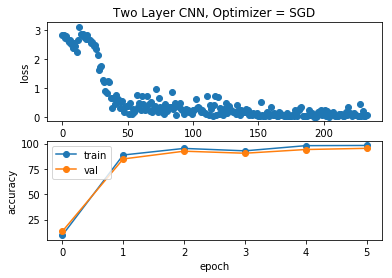

In [29]:
channel_1 = 8
channel_2 = 8
learning_rate = 1e-2

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
two_cnn_model = nn.Sequential(
    nn.Conv2d(1, channel_1, 5, stride = 1, padding=2, bias=True),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, stride = 1, padding=1, bias=True),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * resize_shape * resize_shape, num_class),    
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(two_cnn_model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

loss_history, train_acc_history, val_acc_history = train_part34(two_cnn_model, optimizer, epochs = 2)

# plot loss history
plt.subplot(2, 1, 1)
plt.plot(loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Two Layer CNN, Optimizer = SGD')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### One Layer CNN - SGD

Iteration 0, loss = 2.8729
Train accuracy
Got 494 / 3500 correct (14.11)
Val accuracy
Got 85 / 600 correct (14.17)

Iteration 50, loss = 0.3787
Train accuracy
Got 3208 / 3500 correct (91.66)
Val accuracy
Got 523 / 600 correct (87.17)

Iteration 100, loss = 0.3922
Train accuracy
Got 3428 / 3500 correct (97.94)
Val accuracy
Got 577 / 600 correct (96.17)

Iteration 0, loss = 0.0418
Train accuracy
Got 3426 / 3500 correct (97.89)
Val accuracy
Got 567 / 600 correct (94.50)

Iteration 50, loss = 0.1172
Train accuracy
Got 3461 / 3500 correct (98.89)
Val accuracy
Got 581 / 600 correct (96.83)

Iteration 100, loss = 0.1107
Train accuracy
Got 3479 / 3500 correct (99.40)
Val accuracy
Got 582 / 600 correct (97.00)



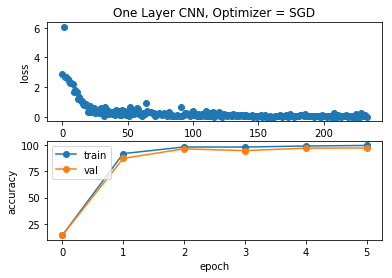

In [43]:
channel_1 = 8
channel_2 = 8
learning_rate = 1e-2

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
one_cnn_model = nn.Sequential(
    nn.Conv2d(1, channel_1, 5, stride = 1, padding=2, bias=True),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_1 * resize_shape * resize_shape, num_class),    
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(one_cnn_model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

loss_history, train_acc_history, val_acc_history = train_part34(one_cnn_model, optimizer, epochs = 2)

# plot the loss and acc history
plt.subplot(2, 1, 1)
plt.plot(loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('One Layer CNN, Optimizer = SGD')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### Two Layer Fully Connected Nerual Network

Iteration 0, loss = 2.7521
Train accuracy
Got 302 / 3500 correct (8.63)
Val accuracy
Got 55 / 600 correct (9.17)

Iteration 50, loss = 0.7047
Train accuracy
Got 2961 / 3500 correct (84.60)
Val accuracy
Got 502 / 600 correct (83.67)

Iteration 100, loss = 0.5109
Train accuracy
Got 3146 / 3500 correct (89.89)
Val accuracy
Got 532 / 600 correct (88.67)

Iteration 0, loss = 0.1270
Train accuracy
Got 3273 / 3500 correct (93.51)
Val accuracy
Got 541 / 600 correct (90.17)

Iteration 50, loss = 0.5939
Train accuracy
Got 3307 / 3500 correct (94.49)
Val accuracy
Got 557 / 600 correct (92.83)

Iteration 100, loss = 0.3320
Train accuracy
Got 3383 / 3500 correct (96.66)
Val accuracy
Got 565 / 600 correct (94.17)



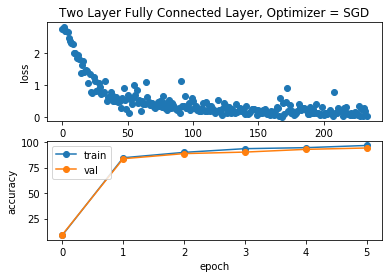

In [44]:
hidden_layer_size = 50
learning_rate = 1e-2

fcn_model = nn.Sequential(
    Flatten(),
    nn.Linear(1 * resize_shape * resize_shape, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, num_class),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(fcn_model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

loss_history, train_acc_history, val_acc_history = train_part34(fcn_model, optimizer, epochs = 2)

# plot the loss and acc history
plt.subplot(2, 1, 1)
plt.plot(loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Two Layer Fully Connected Layer, Optimizer = SGD')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### Two Layer CNN - adam optimizer

Iteration 0, loss = 2.8670
Train accuracy
Got 326 / 3500 correct (9.31)
Val accuracy
Got 56 / 600 correct (9.33)

Iteration 50, loss = 0.5358
Train accuracy
Got 3227 / 3500 correct (92.20)
Val accuracy
Got 533 / 600 correct (88.83)

Iteration 100, loss = 0.3866
Train accuracy
Got 3367 / 3500 correct (96.20)
Val accuracy
Got 565 / 600 correct (94.17)

Iteration 0, loss = 0.0939
Train accuracy
Got 3399 / 3500 correct (97.11)
Val accuracy
Got 563 / 600 correct (93.83)

Iteration 50, loss = 0.2173
Train accuracy
Got 3448 / 3500 correct (98.51)
Val accuracy
Got 577 / 600 correct (96.17)

Iteration 100, loss = 0.0761
Train accuracy
Got 3474 / 3500 correct (99.26)
Val accuracy
Got 583 / 600 correct (97.17)



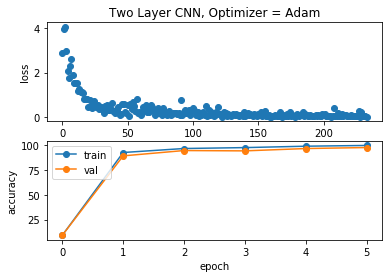

In [45]:
channel_1 = 8
channel_2 = 8
learning_rate = 1e-3

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
two_cnn_model2 = nn.Sequential(
    nn.Conv2d(1, channel_1, 5, stride = 1, padding=2, bias=True),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, stride = 1, padding=1, bias=True),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * resize_shape * resize_shape, num_class),    
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.Adam(two_cnn_model2.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

loss_history, train_acc_history, val_acc_history = train_part34(two_cnn_model2, optimizer, epochs = 2)

# plot the loss and acc history
plt.subplot(2, 1, 1)
plt.plot(loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Two Layer CNN, Optimizer = Adam')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [48]:
print('Test accuracy of 2 Layer CNN with SGD: %.2f' % check_accuracy_part34(data_test, two_cnn_model))
print('Test accuracy of 2 Layer CNN with Adam: %.2f' % check_accuracy_part34(data_test, two_cnn_model2))
print('Test accuracy of 1 Layer CNN with SGD: %.2f' % check_accuracy_part34(data_test, one_cnn_model))
print('Test accuracy of 2 Layer FCN with SGD: %.2f' % check_accuracy_part34(data_test, fcn_model))

Got 654 / 691 correct (94.65)
Test accuracy of 2 Layer CNN with SGD: 94.65
Got 671 / 691 correct (97.11)
Test accuracy of 2 Layer CNN with Adam: 97.11
Got 672 / 691 correct (97.25)
Test accuracy of 1 Layer CNN with SGD: 97.25
Got 656 / 691 correct (94.93)
Test accuracy of 2 Layer FCN with SGD: 94.93


Confusion matrix, without normalization
[[38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 53  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0 73  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 51  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0 26  0  1  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  8  1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  2  0  0 59  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 49  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 35  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 40  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 83  1  0  0]
 [ 0  0  0  1  0  0  0  1  0  0  0  0  0 52  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12]]


NameError: name 'itertools' is not defined

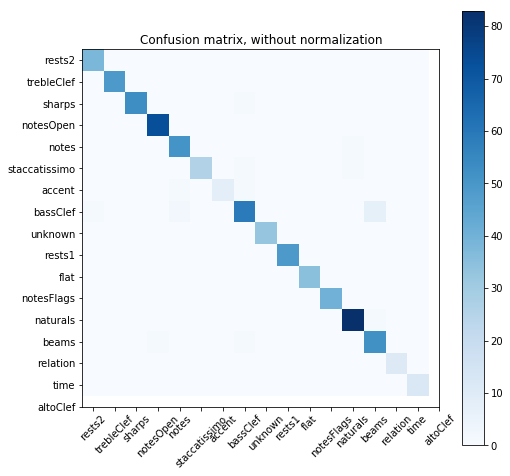

In [65]:
# plot the confusion matrix in a nice way
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
one_cnn_model.eval()  # one layer cnn turned out to perform the best on test data
y_preds = []
y_true = []
with torch.no_grad():
    for x, y in data_test:
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
        y_true.append(y.numpy())
        scores = one_cnn_model(x)
        _, preds = scores.max(1)
        y_preds.append(preds.numpy())
        
# print(np.concatenate(y_preds, axis = 0))
# print('  s')
# print(y_true)
cm = confusion_matrix(np.concatenate(y_true, axis = 0), np.concatenate(y_preds, axis = 0))

# Plot non-normalized confusion matrix
plt.figure(figsize = (8,8))
plot_confusion_matrix(cm, classes=label_type,
                      title='Confusion matrix, without normalization')

In [61]:
label_type

['rests2',
 'trebleClef',
 'sharps',
 'notesOpen',
 'notes',
 'staccatissimo',
 'accent',
 'bassClef',
 'unknown',
 'rests1',
 'flat',
 'notesFlags',
 'naturals',
 'beams',
 'relation',
 'time',
 'altoClef']